In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

gender_submission.csv
test.csv
train.csv



In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def param_selection(clf, X, y, nfolds):
    max_features = ['sqrt', 'auto', 'log2']
    max_depth = range(1, 30, 5)
    min_samples_split = range(2, 10, 2)
    min_samples_leaf = range(1, 10, 2)
    param_grid = {'max_features': max_features, 
                  'max_depth' : max_depth, 
                  'min_samples_split' : min_samples_split,
                 'min_samples_leaf' : min_samples_leaf,}
    grid_search = GridSearchCV(clf, param_grid, cv=nfolds)
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

In [4]:
def transSymbol(x):
    lb = preprocessing.LabelBinarizer()
    lb.fit(x)
    return lb.transform(x)

def transAll(X):  
    # 缺項處理
    #train_data = train_data.dropna()
    X = X.fillna({'Age': 0, 
                'Fare': 0, 
                'Embarked': 'N/A'})

    # 轉換性別
    X['Sex'] = transSymbol(X['Sex'])
    # 轉換艙號
    X['Cabin'] = transSymbol(X['Cabin'].notnull())
    # 轉換登船港口
    X['Embarked'] = transSymbol(X['Embarked'])
    # 轉換名字
    X['Name'] = X['Name'].apply(len)
    X['Name'] = (X['Name'] - X['Name'].mean()) / X['Name'].std()
    
    X['Ticket'] = X['Ticket'].apply(len)
    
    X['Family'] = X['SibSp'] + X['Parch']
    X = X.drop(['SibSp', 'Parch'], axis='columns')
    
    X['Age'] = (X['Age'] - X['Age'].mean()) / X['Age'].std()
    X['Fare'] = (X['Fare'] - X['Fare'].mean()) / X['Fare'].std()
    
    return X

檢查資料與是否有 NA 的項目

In [5]:
train_data = pd.read_csv("../input/train.csv")
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


分析資料

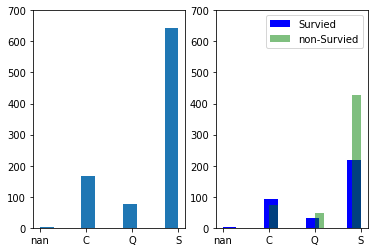

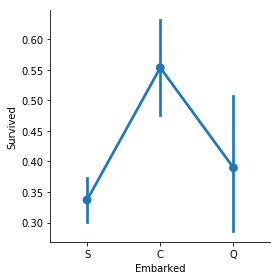

In [7]:
plt.subplot(1, 2, 1)
data = train_data['Embarked']
plt.hist(data)
plt.ylim([0, 700])
plt.subplot(1, 2, 2)
plt.hist(data[train_data.Survived == 1], color='b', label="Survied")
plt.hist(data[train_data.Survived == 0], color='g', label="non-Survied", alpha=0.5)
plt.ylim([0, 700])
plt.legend()
plt.show()
# 顯示中心值與信賴區間
sns.factorplot('Embarked','Survived', data=train_data)

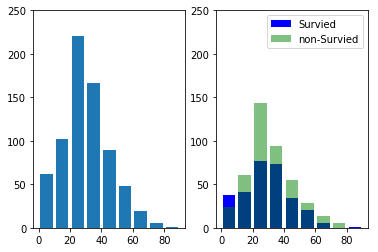

In [8]:
plt.subplot(1, 2, 1)
data = train_data['Age'].dropna(how='any')
plt.hist(data, bins=range(0,100,10), rwidth=0.8)
plt.ylim([0, 250])
plt.subplot(1, 2, 2)
plt.hist(data[train_data.Survived == 1], bins=range(0,100,10), color='b', label="Survied", rwidth=0.8)
plt.hist(data[train_data.Survived == 0], bins=range(0,100,10), color='g', label="non-Survied", rwidth=0.8, alpha=0.5)
plt.ylim([0, 250])
plt.legend()
plt.show()

In [9]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [10]:
X = train_data.drop(['PassengerId', 'Survived'], axis='columns')
X = transAll(X)
y = train_data['Survived']
X.head(10)

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family
0,3,-0.427211,1,-0.102255,9,-0.502163,0,0,1
1,1,2.589508,0,0.807038,8,0.786404,1,1,1
2,3,-0.534951,0,0.125068,16,-0.488580,0,0,0
3,1,1.835328,0,0.636546,6,0.420494,1,0,1
4,3,-0.319471,1,0.636546,6,-0.486064,0,0,0
5,3,-1.181391,1,-1.352534,6,-0.477848,0,0,0
6,1,-0.427211,1,1.716332,5,0.395591,1,0,0
7,3,0.326968,1,-1.238873,6,-0.223957,0,0,4
8,3,2.374028,0,0.181899,6,-0.424018,0,0,2
9,2,0.865668,0,-0.556902,6,-0.042931,0,1,1


In [11]:
print(len(X), len(train_data))

891 891


找出重要的 features

0.829405162738
{'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2}
0.911335578002
0.82379349046
Feature ranking:
1. feature Sex (0.333323)
2. feature Fare (0.152757)
3. feature Name (0.131072)
4. feature Age (0.120325)
5. feature Pclass (0.091010)
6. feature Family (0.061930)
7. feature Ticket (0.051921)
8. feature Cabin (0.046401)
9. feature Embarked (0.011260)


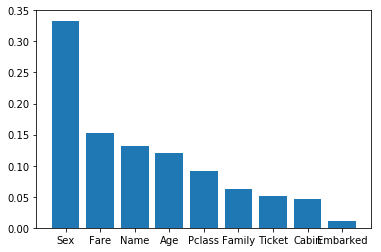

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf, score, para = param_selection(RandomForestClassifier(warm_start=True), X, y, 10)
# cross validation
print(score)
print(para)
# train
rf_clf = clf.set_params(n_estimators=200, oob_score=True)
rf_clf.fit(X, y)
print(rf_clf.score(X,y))
print(rf_clf.oob_score_)

clf = rf_clf
importances = clf.feature_importances_
# 由小到大排序並回傳對應的 index，再將之反向，也就是改為由大到小的排序
indices = np.argsort(importances)[::-1]
 # 印出排序後的 feature 重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.show()

0.829405162738
{'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6}
0.918069584736
0.830527497194
Feature ranking:
1. feature Sex (0.362970)
2. feature Pclass (0.111650)
3. feature Name (0.104067)
4. feature Fare (0.095392)
5. feature Age (0.087924)
6. feature Cabin (0.071017)
7. feature Family (0.070890)
8. feature Ticket (0.068564)
9. feature Embarked (0.027526)


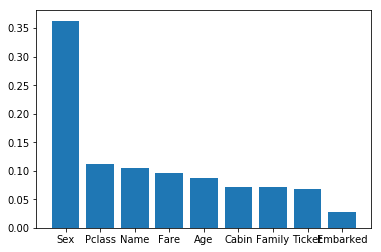

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

clf, score, para = param_selection(ExtraTreesClassifier(warm_start=True), X, y, 10)
# cross validation
print(score)
print(para)
# train
et_clf = clf.set_params(n_estimators=200, oob_score=True, bootstrap=True)
et_clf.fit(X, y)
print(et_clf.score(X,y))
print(et_clf.oob_score_)

clf = et_clf
importances = clf.feature_importances_
# 由小到大排序並回傳對應的 index，再將之反向，也就是改為由大到小的排序
indices = np.argsort(importances)[::-1]
 # 印出排序後的 feature 重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.show()

0.832772166105
Feature ranking:
1. feature Age (0.280000)
2. feature Fare (0.260000)
3. feature Name (0.180000)
4. feature Family (0.100000)
5. feature Ticket (0.080000)
6. feature Sex (0.040000)
7. feature Embarked (0.020000)
8. feature Cabin (0.020000)
9. feature Pclass (0.020000)


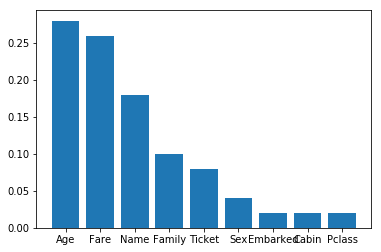

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ab_clf = AdaBoostClassifier()
ab_clf.fit(X, y)
print(ab_clf.score(X,y))

clf = ab_clf
importances = clf.feature_importances_
# 由小到大排序並回傳對應的 index，再將之反向，也就是改為由大到小的排序
indices = np.argsort(importances)[::-1]
 # 印出排序後的 feature 重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.show()

0.833894500561
{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
0.918069584736
Feature ranking:
1. feature Fare (0.254932)
2. feature Age (0.226794)
3. feature Name (0.201145)
4. feature Sex (0.087145)
5. feature Ticket (0.078780)
6. feature Family (0.061909)
7. feature Pclass (0.049090)
8. feature Cabin (0.022409)
9. feature Embarked (0.017797)


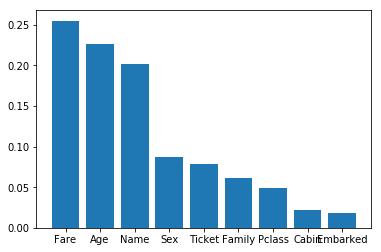

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

clf, score, para = param_selection(GradientBoostingClassifier(warm_start=True), X, y, 10)
# cross validation
print(score)
print(para)
# train
gb_clf = clf.set_params(n_estimators=200)
gb_clf.fit(X, y)
print(gb_clf.score(X,y))

clf = gb_clf
importances = clf.feature_importances_
# 由小到大排序並回傳對應的 index，再將之反向，也就是改為由大到小的排序
indices = np.argsort(importances)[::-1]
 # 印出排序後的 feature 重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.show()

混合模型

In [16]:
X_train = np.concatenate((rf_clf.predict(X)[:, np.newaxis], 
                          et_clf.predict(X)[:, np.newaxis], 
                          ab_clf.predict(X)[:, np.newaxis], 
                          gb_clf.predict(X)[:, np.newaxis]), axis=1)
X_train

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       ..., 
       [0, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0]])

In [17]:
from sklearn.neural_network import MLPClassifier

param_grid = {'hidden_layer_sizes': list(zip(range(1, 10), range(1, 10)))}
grid_search = GridSearchCV(MLPClassifier(max_iter=2000), param_grid, cv=5)
grid_search.fit(X_train, y)

mlp = grid_search.best_estimator_
print("Training set score: %f" % mlp.score(X_train, y))
grid_search.best_score_, grid_search.best_params_

Training set score: 0.925926


(0.92031425364758701, {'hidden_layer_sizes': (5, 5)})

In [18]:
test_data = pd.read_csv("../input/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [20]:
X_test = test_data.drop(['PassengerId'], axis=1)
X_test = transAll(X_test)
X_test.head()

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family
0,3,-1.151639,1,0.594089,6,-0.496043,0,0,0
1,3,0.452978,0,1.304333,6,-0.510885,0,0,1
2,2,-0.249042,1,2.156624,6,-0.462780,0,0,0
3,3,-1.151639,1,0.167944,6,-0.481127,0,0,0
4,3,1.656441,0,-0.116154,7,-0.416242,0,0,2


In [21]:
X_test = np.concatenate((rf_clf.predict(X_test)[:, np.newaxis], 
                          et_clf.predict(X_test)[:, np.newaxis], 
                          ab_clf.predict(X_test)[:, np.newaxis], 
                          gb_clf.predict(X_test)[:, np.newaxis]), axis=1)

X_test

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [22]:
y_predict = mlp.predict(X_test)

In [23]:
results = pd.DataFrame({
    'PassengerId' : test_data['PassengerId'],
    'Survived' : y_predict
 })
results.to_csv("output.csv", index=False)